In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/kalidus/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Smart Cities network design calculations

# Power & Distance calculations

 $P_{Tx}-P_{L}(d)=P_{Rx_{min}}$               Eq.(1)           

<img src='perdidas.png'></img>

In [43]:
class PowerCalc:
    def __init__(self,ptx=None,prx=None,d=None):
        self.Ptx=ptx
        self.Prx=prx
        self.D=d
        
    def PL(self,d):
        """Path loss function as described in the image above"""
        if d <=8:
            return 40.2+20*np.log10(d)
        else:
            return 58.5+33*np.log10(d/8.0)   

    def antilog(self,x):
        return 10 ** x

    def maxDist(self,ptx,prx,verbose=False):
        thres=pc.PL(8)
        PL=ptx-prx
        if PL<=thres:
            dist=self.antilog((PL-40.2)/20.0)
        else:
            dist=self.antilog((PL-58.5)/33.0)*8
        if verbose:
            print("POWER PARAMETERS:\n Ptx: {}dBm\n Prx:{}dBm\n\nMaximum distance: {}m".format(ptx,prx,np.round(dist,2)))
        return dist
        
        
    def power(self,d,ptx,prx,target='Tx',verbose=False):
        if target=='Tx':
            if verbose:
                print("INPUT DATA:\n Distance: {}m\n Prx: {}dBm\n\nTARGET\n Ptx: {}dBm".format(d,prx,ptx))
            return prx+self.PL(d)
        else:
            if verbose:
                print("INPUT DATA:\n Distance: {}m\n Ptx: {}dBm\n\nTARGET\n Prx: {}dBm".format(d,ptx,prx))
            return ptx-self.PL(d)        
        
    def calculate(self,target='D',d=None,ptx=None,prx=None, verbose=True):
        """Calculates Eq.(1) for the target parameter given the other two parameters are known"""
        a= d is not None
        b= ptx is not None
        c= prx is not None
        if a:
            D=d
        else:
            D=self.D
        if b:
            Ptx=ptx
        else:
            Ptx=self.Ptx
        if c:
            Prx=prx
        else:
            Prx=self.Prx     
            
        if target=="D":
            return self.maxDist(Ptx,Prx,verbose)
        elif target=='Tx':
            return self.power(D,Ptx,Prx,verbose=verbose)
        elif target=='Rx':
            return self.power(D,Ptx,Prx,target='Rx',verbose=verbose)
        

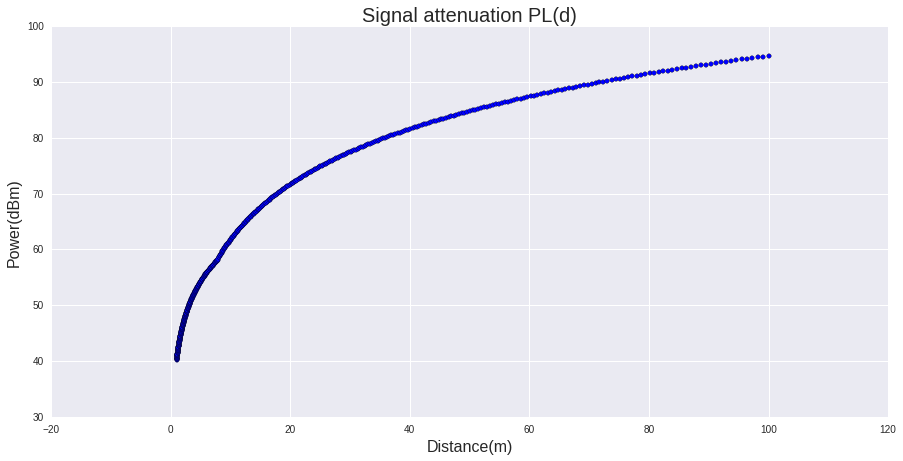

In [44]:
pc=PowerCalc()
ds=np.logspace(start=0,stop=2,num=500)
plt.figure(figsize=(15,7))
plt.scatter(ds,[pc.PL(d) for d in ds])
plt.title('Signal attenuation PL(d)',fontsize=20)
plt.xlabel('Distance(m)',fontsize=16)
a=plt.ylabel("Power(dBm)",fontsize=16)

In [45]:
pc=PowerCalc(ptx=0,prx=-85.0)
pc.calculate(target='D',verbose=True)#exemple diapositives

POWER PARAMETERS:
 Ptx: 0dBm
 Prx:-85.0dBm

Maximum distance: 50.83m


50.83002110467587

In [46]:
pc.calculate(target='Tx',ptx=2.3,d=75,verbose=True)

INPUT DATA:
 Distance: 75m
 Prx: -85.0dBm

TARGET
 Ptx: 2.3dBm


5.575052121191959

## Delay calculations

### Physical layer frame

<img src='physical.png'></img>

### MAC layer frame

<img src='MAC.png'></img>


### Frame delay with ACK

<img src='Tack.png'></img>

### Frame delay without ACK

<img src='Tnack.png'></img>

$T_{BO}=n_{BO}·20·T_{SYM}$

$T_{TA}=12·T_{SYM}$

$T_{ACK}=10·T_{SYM}$ 

$T_{Frame}=PHY_{Header}+3Bytes+Addressing Bytes+PAYLOAD+Footer$

In [64]:
from IPython.display import display, Math, Latex

In [93]:
def Tframe(payload=118,inf_address=4,Tsim_us=16):
    "Calculates the time duration of a frame in miliseconds"
    PHY_layer=8
    num_bytes=PHY_layer+3+inf_address+payload+2
    Tf=num_bytes*2*Tsim_us/1000.0
    return Tf

def Tifs(payload=20,Tsim_us=16):
    "Calculates Tifs according to slides"
    if payload<=13:
        return 12*Tsim_us/1000.0
    else:
        return 40*Tsim_us/1000.0

def delay_1_jump(payload=118,inf_address=4,Tsim_us=16,ack=True,BE=3,verbose=False):
    "Calculates de mean delay in one jump in miliseconds. Assumes modulation QPSK"
    Tsim_ms=Tsim_us/1000
    E_nbo=(2**(BE-1))/2
    E_Tbo=20*Tsim_ms*E_nbo
    Tfr=Tframe(payload,inf_address,Tsim_us)
    Tif=Tifs(payload,Tsim_us)
    if ack:
        Tta=12*Tsim_ms
        Tack=10*Tsim_ms  
        if verbose:
            print('Address bytes:{}, Bytes payload:{}, with ACK'.format(inf_address,payload))
            print('E[Tbo]: {} ms, T_frame: {} ms, T_toack: {} ms,T_ack:{} ms,T_IFS: {} ms \nTotal time for one frame: {} ms'.format(E_Tbo,Tfr,Tta,Tack,Tif,round(E_Tbo+Tfr+Tta+Tack+Tif,3)))
        return E_Tbo+Tfr+Tta+Tack+Tif
    else:
        if verbose:
            print('Address bytes:{}, Bytes payload:{}, without ACK'.format(inf_address,payload))
            print('E[Tbo]: {} ms, T_frame: {} ms,T_IFS: {} ms \nTotal time for one frame: {} ms'.format(E_Tbo,Tfr,Tif,round(E_Tbo+Tfr+Tif,3)))
        return E_Tbo+Tfr+Tif


In [94]:
delay_1_jump(payload=118,inf_address=4,ack=False,verbose=True)

Address bytes:4, Bytes payload:118, without ACK
E[Tbo]: 0.64ms, T_frame: 4.064ms,T_IFS: 0.64ms 
Total time for one frame: 5.344ms


5.343999999999999

## Battery lifetime estimations

$Life (hours)=\frac{Battery (mAh)}{I_{Avg}}$

$I_{Avg}=\sum a_k I_k$

For a CC2430 chip the average current consumption during a duty cicle is 20.37mA during 6.9ms

In [56]:
def life_CC2430(events_hour,battery=235.0):
    "Battery life estimation based on duty cicles per hour"
    Isleep=0.0005 #sleep current of 0.5uA
    Icicle=20.37403698 #consumes 20.37 mA in a duty cicle lasting 6.49ms
    a=Isleep*3600/(3600+0.00649*events_hour) #percentage of time spend in sleep mode
    b=Icicle*0.00649*events_hour/(3600+0.00649*events_hour) #percentage of time active
    return (battery/(a+b))/(24*365)

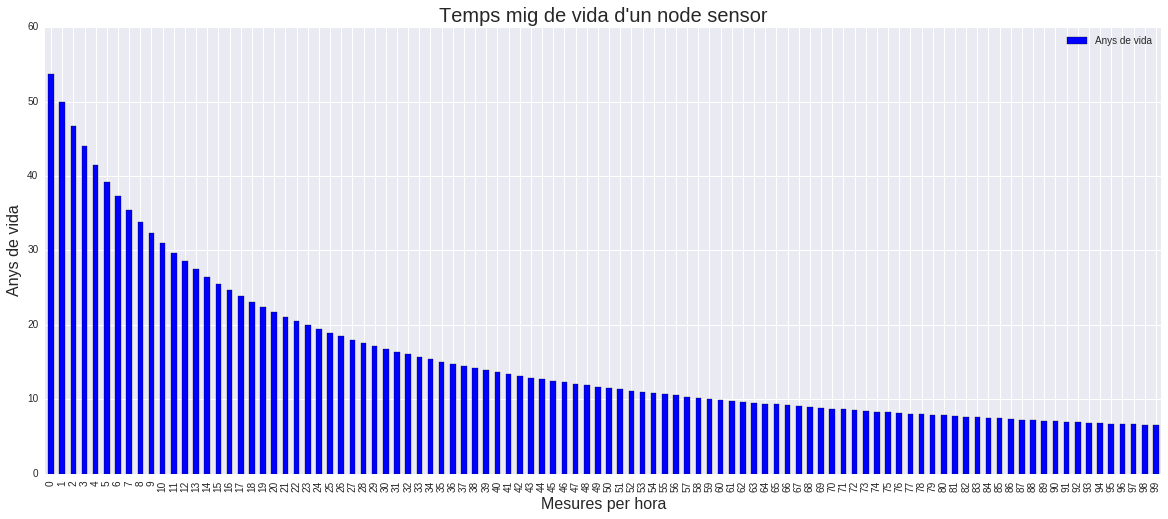

In [61]:
values=np.arange(100)

df=pd.DataFrame(data=life_CC2430(values),columns=['Anys de vida'])
df.index.name='Mesures per hora'
df.plot(kind='bar',figsize=(20,8))
plt.title("Temps mig de vida d'un node sensor",fontsize=20)
plt.xlabel('Mesures per hora',fontsize=16)
dump=plt.ylabel("Anys de vida",fontsize=16)
#plt.savefig('mesures.png')